In [19]:
# Cell 1: Load and preprocess data
import pandas as pd
import torch

log_returns = pd.read_csv("AlphaPortfolio_Dataset.csv", index_col=0, parse_dates=True)
log_returns = log_returns.dropna(axis=1, thresh=len(log_returns) * 0.9).fillna(0)
log_returns = log_returns.apply(pd.to_numeric, errors='coerce')
subset = log_returns.loc[:, log_returns.isnull().sum().sort_values().index[:500]]
subset = subset.dropna()

returns_tensor = torch.tensor(subset.values, dtype=torch.float32)
log_returns = subset.copy()


In [20]:
# Cell 2: Define portfolio statistics helper functions

def portfolio_stats(weights, returns):
    mean_returns = returns.mean(axis=0)
    cov_matrix = returns.cov()
    port_return = torch.dot(weights, torch.tensor(mean_returns.values, dtype=torch.float32))
    port_vol = torch.sqrt(weights @ torch.tensor(cov_matrix.values, dtype=torch.float32) @ weights)
    return port_return, port_vol

def max_drawdown(weights, returns):
    portfolio_returns = returns @ weights.detach().numpy()
    cumulative = (1 + portfolio_returns).cumprod()
    peak = cumulative.cummax()
    drawdowns = (cumulative - peak) / peak
    max_dd = drawdowns.min()  # most negative value
    return torch.tensor(abs(max_dd), dtype=torch.float32)

def entropy(weights):
    return -(weights * torch.log(weights + 1e-8)).sum()

def downside_risk(portfolio_returns):
    negative_returns = portfolio_returns[portfolio_returns < 0]
    if len(negative_returns) == 0:
        return torch.tensor(0.0)
    return torch.sqrt((negative_returns ** 2).mean())


In [21]:
# Cell 3: Define custom loss function

def custom_loss(weights, returns, lambda_return=1.0, lambda_vol=0.5, lambda_dd=0.7, lambda_ent=0.3):
    port_return, port_vol = portfolio_stats(weights, returns)
    dd = max_drawdown(weights, returns)
    ent = entropy(weights)
    
    loss = (-lambda_return * port_return
            + lambda_vol * port_vol
            + lambda_dd * dd
            - lambda_ent * ent)
    return loss, port_return, port_vol, dd, ent


In [22]:

import numpy as np
import pandas as pd
from scipy.optimize import minimize

# === Portfolio strategies ===
def equal_weighted(n_assets):
    return np.ones(n_assets) / n_assets


def risk_parity(cov_matrix):
    inv_vol = 1.0 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / np.sum(inv_vol)
    return weights

def equal_risk_contribution(cov_matrix):
    n = len(cov_matrix)
    x0 = np.ones(n) / n
    def portfolio_risk(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)
    def risk_contribution(weights):
        port_risk = portfolio_risk(weights)
        return weights * (cov_matrix @ weights) / port_risk
    def objective(weights):
        rc = risk_contribution(weights)
        return np.sum((rc - rc.mean())**2)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0.0, 1.0)] * n
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


In [23]:
def alpha_portfolio(mean_returns, cov_matrix, epsilon=1e-4, delta=1e-6, tau=0.01, entropy_strength=0.5, boost_factor=0.3):
    # Step 1: Inverse covariance risk-adjusted returns
    inv_cov = np.linalg.inv(cov_matrix + epsilon * np.eye(len(cov_matrix)))
    radj = inv_cov @ mean_returns

    # Step 2: Soft-threshold radj to keep useful negatives
    radj = np.sign(radj) * np.maximum(0, np.abs(radj) - tau)

    # Step 3: Softmax-normalized weighting with volatility normalization
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    scaled_radj = radj * (1 + np.std(radj))
    denom = np.sqrt(np.diag(cov_matrix)) + epsilon
    softmax_input = scaled_radj / denom
    weights = softmax(softmax_input)

    # ✅ Step 4: Boost exposure to high radj directions
    radj_positive = np.maximum(radj, 0)
    if np.sum(radj_positive) > 0:
        radj_dir = radj_positive / np.sum(radj_positive)
        weights = (1 - boost_factor) * weights + boost_factor * radj_dir
    weights = np.clip(weights, 0, 1)
    weights = weights / np.sum(weights)

    # Step 5: Entropy-based regularization
    entropy_penalty = np.mean(weights) * np.log(weights + delta)
    weights = weights * np.exp(entropy_strength * entropy_penalty)

    # Step 6: Normalize final weights to sum to 1
    weights = weights / np.sum(weights)

    return weights


In [24]:

def sharpe_ratio(returns, risk_free_rate=0.0):
    return (returns.mean() - risk_free_rate) / returns.std()

def sortino_ratio(returns, target=0):
    downside = returns[returns < target]
    return (returns.mean() - target) / np.sqrt((downside**2).mean())

def calmar_ratio(returns):
    returns = pd.Series(returns)
    cum_return = (1 + returns).cumprod()
    max_dd = (cum_return / cum_return.cummax() - 1).min()
    return returns.mean() / abs(max_dd) if max_dd != 0 else np.nan

def max_drawdown(returns):
    returns = pd.Series(returns)
    cum_return = (1 + returns).cumprod()
    drawdown = cum_return / cum_return.cummax() - 1
    return drawdown.min()

In [25]:
# 🔍 Simulated LLM Strategy Discovery and Evaluation (Fixed Version)

import torch
import numpy as np

# === Simulated LLM-Generated Portfolio Strategies ===
def strategy_v1(returns):
    """Mean divided by volatility, then softmaxed"""
    scores = returns.mean(dim=1) / (returns.std(dim=1) + 1e-6)
    return torch.softmax(scores, dim=0)

def strategy_v2(returns):
    """Inverse Covariance-weighted return"""
    cov = torch.cov(returns)
    eye = torch.eye(cov.size(0))
    inv_cov = torch.inverse(cov + 1e-4 * eye)
    radj = inv_cov @ returns.mean(dim=1)
    return torch.softmax(radj, dim=0)

def strategy_v3(returns):
    """Entropy-weighted softmax returns"""
    base = returns.mean(dim=1)
    softmaxed = torch.softmax(base, dim=0)
    entropy = -torch.sum(softmaxed * torch.log(softmaxed + 1e-6))
    return softmaxed * (1 + entropy)

strategies = [strategy_v1, strategy_v2, strategy_v3]
strategy_names = ["Mean/Volatility", "Inverse Covariance", "Entropy Weighted"]

# === Sharpe Ratio Scoring ===
def score_strategy(strategy_fn, returns):
    weights = strategy_fn(returns)  # [n_assets]
    portfolio_returns = torch.matmul(weights, returns)  # [n_days]
    
    avg_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    sharpe_ratio = avg_return / (std_return + 1e-6)

    return sharpe_ratio.item(), weights

# === Evaluation Loop ===
print("📊 LLM-Simulated Strategy Performance\n---------------------------")
scores = []
for i, strategy in enumerate(strategies):
    score, weights = score_strategy(strategy, returns_tensor)
    scores.append((strategy_names[i], score))
    print(f"Strategy {strategy_names[i]}: Sharpe = {score:.4f}")


📊 LLM-Simulated Strategy Performance
---------------------------
Strategy Mean/Volatility: Sharpe = 1.7966
Strategy Inverse Covariance: Sharpe = -0.3266
Strategy Entropy Weighted: Sharpe = 0.7504


In [26]:
import numpy as np

#Ensure correct shape: (assets x time)
returns = log_returns.T  # Transpose: now rows = assets, columns = time steps

#Compute excess returns
if 'risk_free_rate' in globals():
    # Ensure risk_free_rate is compatible (broadcastable)
    if np.isscalar(risk_free_rate):
        excess_returns = returns - risk_free_rate
    elif len(risk_free_rate) == returns.shape[1]:
        excess_returns = returns - risk_free_rate  # vector subtraction (per time step)
    else:
        raise ValueError("risk_free_rate must be scalar or match time dimension")
else:
    excess_returns = returns

#Mean return and covariance matrix
mean_returns = excess_returns.mean(axis=1)  # mean across time for each asset
cov_matrix = np.cov(excess_returns)         # cov across assets (assets x assets)

# Generate portfolio weights
w_alpha = alpha_portfolio(mean_returns, cov_matrix)
w_ew = equal_weighted(len(mean_returns))
w_rp = risk_parity(cov_matrix)
w_erc = equal_risk_contribution(cov_matrix)

#Compute portfolio returns over time 
excess_returns_np = np.array(excess_returns)

returns_alpha = w_alpha @ excess_returns_np
returns_ew = w_ew @ excess_returns_np
returns_rp = w_rp @ excess_returns_np
returns_erc = w_erc @ excess_returns_np

# Compare performance metrics 
print("\nPerformance Comparison:")
for name, ret in {
    "AlphaPortfolio": returns_alpha,
    "Equal-Weighted": returns_ew,
    "Risk Parity": returns_rp,
    "Equal Risk Contribution": returns_erc,
}.items():
    print(f"{name}:")
    print(f"  Sharpe Ratio:  {sharpe_ratio(ret):.3f}")
    print(f"  Sortino Ratio: {sortino_ratio(ret):.3f}")
    print(f"  Calmar Ratio:  {calmar_ratio(ret):.3f}")
    print(f"  Max Drawdown:  {max_drawdown(ret):.2%}\n")



Performance Comparison:
AlphaPortfolio:
  Sharpe Ratio:  0.061
  Sortino Ratio: 0.056
  Calmar Ratio:  0.002
  Max Drawdown:  -13.32%

Equal-Weighted:
  Sharpe Ratio:  0.020
  Sortino Ratio: 0.018
  Calmar Ratio:  0.001
  Max Drawdown:  -45.01%

Risk Parity:
  Sharpe Ratio:  0.029
  Sortino Ratio: 0.027
  Calmar Ratio:  0.001
  Max Drawdown:  -36.29%

Equal Risk Contribution:
  Sharpe Ratio:  0.020
  Sortino Ratio: 0.018
  Calmar Ratio:  0.001
  Max Drawdown:  -45.01%



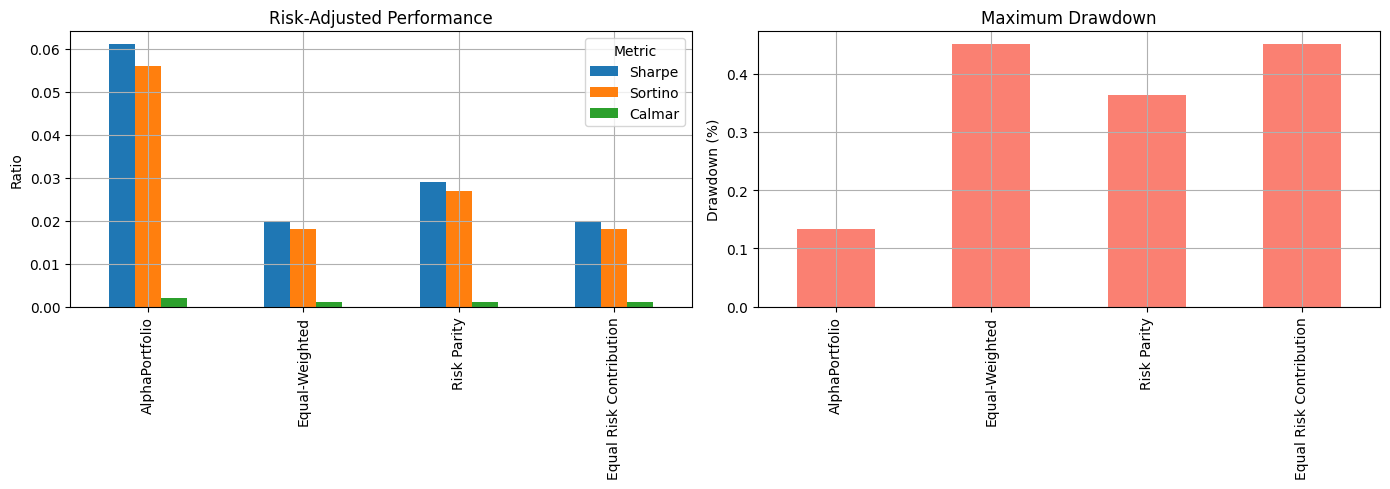

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Performance data
data = {
    "AlphaPortfolio": [0.061, 0.056, 0.002, -0.1332],
    "Equal-Weighted": [0.020, 0.018, 0.001, -0.4501],
    "Risk Parity": [0.029, 0.027, 0.001, -0.3629],
    "Equal Risk Contribution": [0.020, 0.018, 0.001, -0.4501]
}
metrics = ["Sharpe", "Sortino", "Calmar", "Max Drawdown"]

df = pd.DataFrame(data, index=metrics).T

# Plot all except drawdown
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Risk-adjusted returns
df[["Sharpe", "Sortino", "Calmar"]].plot(kind='bar', ax=ax[0])
ax[0].set_title("Risk-Adjusted Performance")
ax[0].set_ylabel("Ratio")
ax[0].grid(True)
ax[0].legend(title="Metric")

# Drawdowns (invert to show as positive for visual clarity)
df["Max Drawdown"].abs().plot(kind='bar', ax=ax[1], color='salmon')
ax[1].set_title("Maximum Drawdown")
ax[1].set_ylabel("Drawdown (%)")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_cumulative_returns(returns_dict):
    # Convert all to Series, clean data, and truncate to min length
    cleaned_returns = {}
    min_len = min(len(ret) for ret in returns_dict.values())

    for label, ret in returns_dict.items():
        series = pd.Series(ret).fillna(0).replace([np.inf, -np.inf], 0)[:min_len]
        cleaned_returns[label] = series

    # Extract Equal-Weighted separately
    ew_series = cleaned_returns.pop("Equal-Weighted", None)

    # Plot all except Equal-Weighted
    plt.figure(figsize=(10, 6))
    colors = {
        "AlphaPortfolio": "blue",
        "Risk Parity": "green",
        "Equal Risk Contribution": "red"
    }

    for label, series in cleaned_returns.items():
        try:
            cumulative = (1 + series).cumprod()
            plt.plot(cumulative, label=label, color=colors.get(label, None))
        except Exception as e:
            print(f"Error plotting {label}: {e}")
    
    plt.title("Cumulative Returns (excluding Equal-Weighted)")
    plt.xlabel("Time")
    plt.ylabel("Growth of $1")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Equal-Weighted separately
    if ew_series is not None:
        print("Equal-Weighted return summary:")
        print(ew_series.describe())

        plt.figure(figsize=(10, 4))
        try:
            cumulative_ew = (1 + ew_series).cumprod()
            plt.plot(cumulative_ew, label="Equal-Weighted", color="orange")
            plt.title("Cumulative Returns - Equal-Weighted")
            plt.xlabel("Time")
            plt.ylabel("Growth of $1")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting Equal-Weighted: {e}")


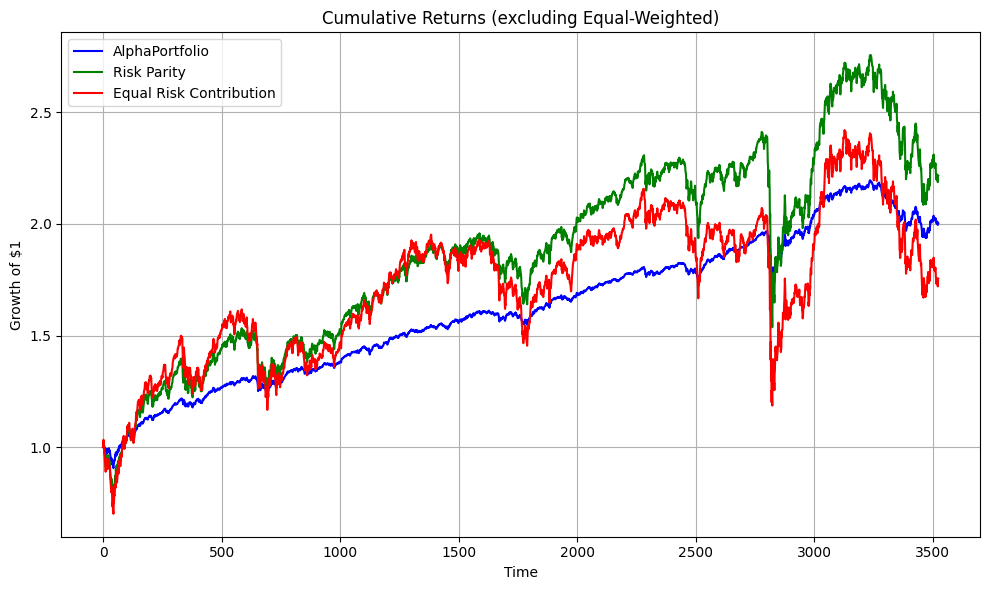

Equal-Weighted return summary:
count    3524.000000
mean        0.000227
std         0.011533
min        -0.118580
25%        -0.004686
50%         0.000705
75%         0.005692
max         0.081317
dtype: float64


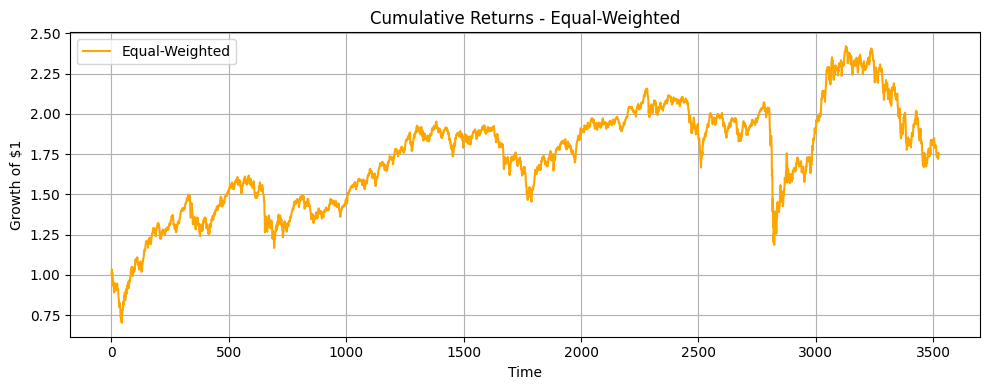

In [30]:
plot_cumulative_returns({
    "AlphaPortfolio": returns_alpha,
    "Equal-Weighted": returns_ew,
    "Risk Parity": returns_rp,
    "Equal Risk Contribution": returns_erc
})


📊 Out-of-Sample Sharpe Ratio: 0.0305
📈 Final cumulative return: 1.09x


C:\Users\vansh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


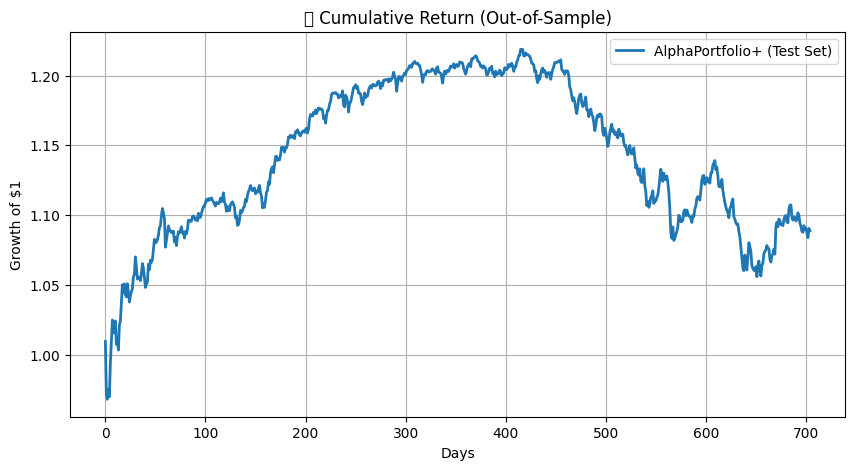

In [31]:
# --- Convert DataFrame to NumPy array ---
returns_np = returns.to_numpy()

# --- Split the data ---
n_days = returns_np.shape[1]
split_idx = int(n_days * 0.8)

returns_train = returns_np[:, :split_idx]
returns_test  = returns_np[:, split_idx:]

# --- Compute mean & cov on training set ---
mean_train = np.mean(returns_train, axis=1)
cov_train = np.cov(returns_train)

# --- Get weights from AlphaPortfolio trained on training data ---
weights = alpha_portfolio(
    mean_returns=mean_train,
    cov_matrix=cov_train,
    epsilon=1e-4,
    entropy_strength=0.5,
    boost_factor=0.3
)

# --- Apply weights to test data ---
test_portfolio_returns = weights @ returns_test
test_sharpe = np.mean(test_portfolio_returns) / (np.std(test_portfolio_returns) + 1e-6)
test_cum_return = np.cumprod(1 + test_portfolio_returns)

# --- Print results ---
print(f"📊 Out-of-Sample Sharpe Ratio: {test_sharpe:.4f}")
print(f"📈 Final cumulative return: {test_cum_return[-1]:.2f}x")

# --- Plot returns ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test_cum_return, label="AlphaPortfolio+ (Test Set)", linewidth=2)
plt.title("📈 Cumulative Return (Out-of-Sample)")
plt.xlabel("Days")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
def alpha_portfolio_ablation(mean_returns, cov_matrix,
                              epsilon=1e-4, delta=1e-6, tau=0.01,
                              entropy_strength=0.5, boost_factor=0.3,
                              use_entropy=True, use_boost=True, use_volatility_norm=True):
    
    inv_cov = np.linalg.inv(cov_matrix + epsilon * np.eye(len(cov_matrix)))
    radj = inv_cov @ mean_returns

    # Soft-thresholding
    radj = np.sign(radj) * np.maximum(0, np.abs(radj) - tau)

    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    # Volatility normalization
    scaled_radj = radj * (1 + np.std(radj))
    if use_volatility_norm:
        denom = np.sqrt(np.diag(cov_matrix)) + epsilon
    else:
        denom = 1
    softmax_input = scaled_radj / denom
    weights = softmax(softmax_input)

    # Boosting
    if use_boost:
        radj_positive = np.maximum(radj, 0)
        if np.sum(radj_positive) > 0:
            radj_dir = radj_positive / np.sum(radj_positive)
            weights = (1 - boost_factor) * weights + boost_factor * radj_dir

    weights = np.clip(weights, 0, 1)
    weights = weights / np.sum(weights)

    # Entropy-based regularization
    if use_entropy:
        entropy_penalty = np.mean(weights) * np.log(weights + delta)
        weights = weights * np.exp(entropy_strength * entropy_penalty)

    # Final normalization
    weights = weights / np.sum(weights)

    return weights


In [14]:
ablation_versions = {
    "Full AlphaPortfolio": (True, True, True),
    "No Entropy": (False, True, True),
    "No Boosting": (True, False, True),
    "No Volatility Norm": (True, True, False)
}

print("📊 Out-of-Sample Sharpe Ratios for Ablation Versions:")
for label, (ent, boost, volnorm) in ablation_versions.items():
    weights = alpha_portfolio_ablation(
        mean_returns=mean_train,
        cov_matrix=cov_train,
        use_entropy=ent,
        use_boost=boost,
        use_volatility_norm=volnorm
    )

    returns_eval = weights @ returns_test
    sharpe = np.mean(returns_eval) / (np.std(returns_eval) + 1e-6)
    print(f"{label:25}: Sharpe = {sharpe:.4f}")


📊 Out-of-Sample Sharpe Ratios for Ablation Versions:
Full AlphaPortfolio      : Sharpe = 0.0305
No Entropy               : Sharpe = 0.0306
No Boosting              : Sharpe = -0.0230
No Volatility Norm       : Sharpe = 0.0405


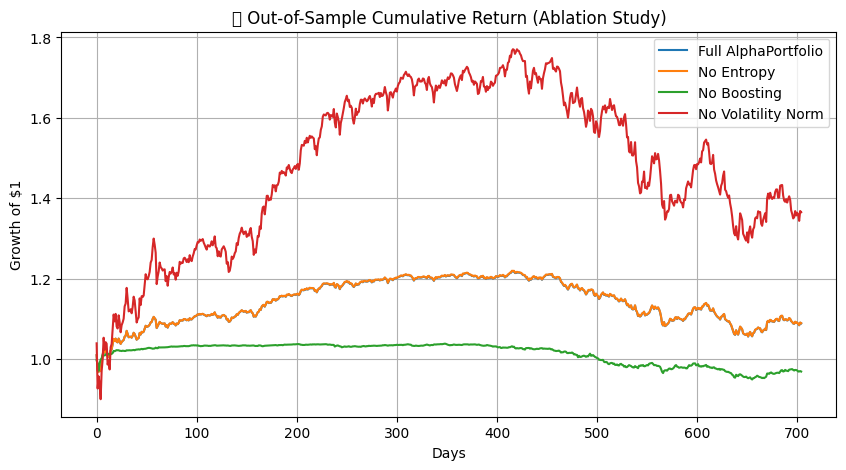

In [15]:
plt.figure(figsize=(10, 5))
for label, (ent, boost, volnorm) in ablation_versions.items():
    weights = alpha_portfolio_ablation(
        mean_returns=mean_train,
        cov_matrix=cov_train,
        use_entropy=ent,
        use_boost=boost,
        use_volatility_norm=volnorm
    )
    test_returns = weights @ returns_test
    cum_ret = np.cumprod(1 + test_returns)
    plt.plot(cum_ret, label=label)

plt.title("📈 Out-of-Sample Cumulative Return (Ablation Study)")
plt.xlabel("Days")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


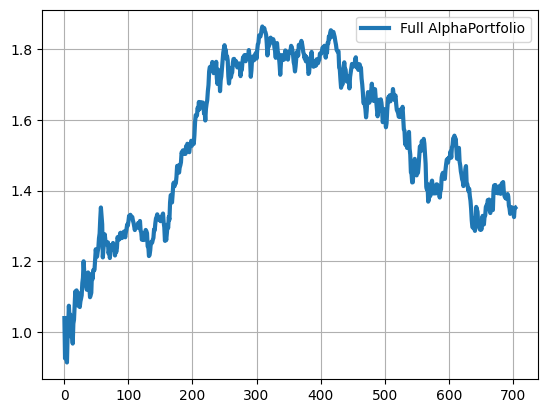

In [16]:
weights = alpha_portfolio_ablation(mean_train, cov_train, True, True, True)
returns_eval = weights @ returns_test
cum_ret = np.cumprod(1 + returns_eval)

plt.plot(cum_ret, label="Full AlphaPortfolio", linewidth=3)
plt.grid(True)
plt.legend()
plt.show()


In [33]:
def lean_alpha_portfolio(mean_returns, cov_matrix,
                         epsilon=1e-4, tau=0.01, boost_factor=0.3):
    """
    Lean version of AlphaPortfolio:
    - Inverse covariance weighting
    - Soft-thresholding
    - Boosting based on positive risk-adjusted returns
    - No entropy regularization
    - No volatility normalization
    """
    # Step 1: Inverse covariance risk-adjusted returns
    inv_cov = np.linalg.inv(cov_matrix + epsilon * np.eye(len(cov_matrix)))
    radj = inv_cov @ mean_returns

    # Step 2: Soft-threshold radj
    radj = np.sign(radj) * np.maximum(0, np.abs(radj) - tau)

    # Step 3: Softmax weighting
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    weights = softmax(radj)

    # Step 4: Boost exposure to strong signals
    radj_positive = np.maximum(radj, 0)
    if np.sum(radj_positive) > 0:
        radj_dir = radj_positive / np.sum(radj_positive)
        weights = (1 - boost_factor) * weights + boost_factor * radj_dir

    # Final normalization
    weights = np.clip(weights, 0, 1)
    weights = weights / np.sum(weights)

    return weights


📊 Lean AlphaPortfolio Sharpe: 0.0399
📈 Final cumulative return: 1.37x


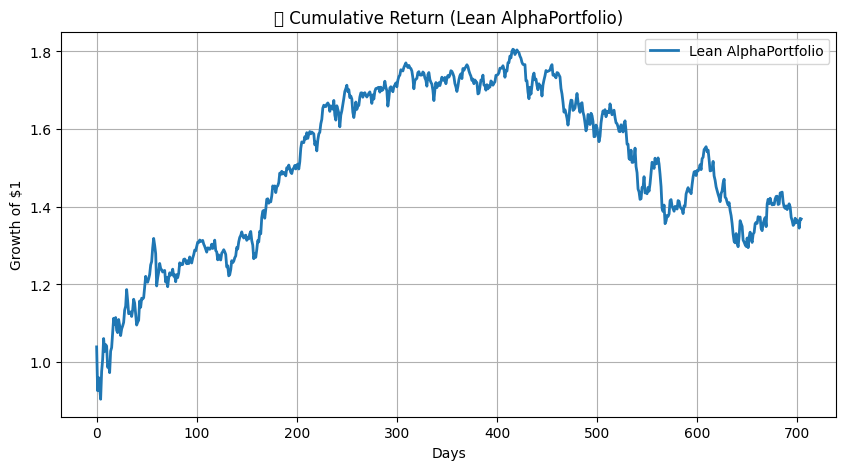

In [18]:
weights = lean_alpha_portfolio(mean_train, cov_train)

returns_eval = weights @ returns_test
sharpe = np.mean(returns_eval) / (np.std(returns_eval) + 1e-6)
cum_ret = np.cumprod(1 + returns_eval)

print(f"📊 Lean AlphaPortfolio Sharpe: {sharpe:.4f}")
print(f"📈 Final cumulative return: {cum_ret[-1]:.2f}x")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cum_ret, label="Lean AlphaPortfolio", linewidth=2)
plt.title("📈 Cumulative Return (Lean AlphaPortfolio)")
plt.xlabel("Days")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()
